## Predict Stock Market Closing Day Prices

### Import Libraries

In [1]:
!pip install keras
!pip install livelossplot
!pip install mcfly

In [2]:
import os
import time
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy import newaxis
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
from keras.optimizers import Adam
from keras import backend as K
from mcfly import find_architecture as mcfly
import livelossplot
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Load Data

In [3]:
def directional_data(threshold, data, seq_len):
    result = []
    sequence_length = seq_len + 1
    for j in range(len(data) - sequence_length):
        i = j + seq_len
        if abs(data[i]-data[i-1]) < threshold:
            result.append([0,1,0])
        elif data[i] > data[i-1]:
            result.append([0,0,1])
        else:
            result.append([1,0,0])
    return result

In [4]:
def load_data(data, seq_len, threshold):
    sequence_length = seq_len + 1
    result = []
    
    closing = data[:,3]
    direction_data = directional_data(threshold,closing,seq_len)
    direction_data = np.array(direction_data)
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length, :])

    result = np.array(result)
    original_data = result.copy()
    
    for index in range(result.shape[2]):
        result[:,:,index] = normalise_windows(result[:,:,index])

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :, :]
    train_y = direction_data[:int(row)]
    x_train = train[:, :-1, :]
    y_train = train_y[:]
    x_test = result[int(row):, :-1, :]
    y_test = direction_data[int(row):]
    original_data = original_data[int(row):, :]
    
    return [x_train, y_train, x_test, y_test, original_data]

In [5]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        if not window[0] == 0:
            normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        else:
            normalised_window = [float(p) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

### Test Model

Training model 0 DeepConvLSTM
Train on 100 samples, validate on 458 samples
Epoch 1/5
100/100 [==============================] - 15s 152ms/step - loss: 0.9889 - acc: 0.4800 - val_loss: 0.9270 - val_acc: 0.4913
Epoch 2/5
100/100 [==============================] - 2s 16ms/step - loss: 0.8373 - acc: 0.5600 - val_loss: 0.8527 - val_acc: 0.5393
Epoch 3/5
100/100 [==============================] - 2s 16ms/step - loss: 0.7855 - acc: 0.5400 - val_loss: 0.8330 - val_acc: 0.5306
Epoch 4/5
100/100 [==============================] - 2s 16ms/step - loss: 0.7903 - acc: 0.5400 - val_loss: 0.8323 - val_acc: 0.5175
Epoch 5/5
100/100 [==============================] - 2s 16ms/step - loss: 0.8000 - acc: 0.5800 - val_loss: 0.8409 - val_acc: 0.5328
Training model 1 DeepConvLSTM
Train on 100 samples, validate on 458 samples
Epoch 1/5
100/100 [==============================] - 7s 72ms/step - loss: 7.0560 - acc: 0.4700 - val_loss: 3.7901 - val_acc: 0.5721
Epoch 2/5
100/100 [==============================] - 3

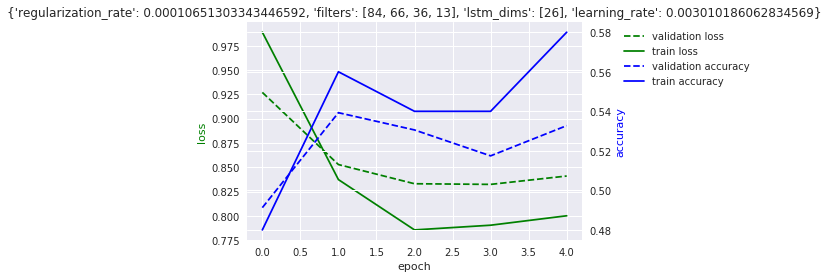

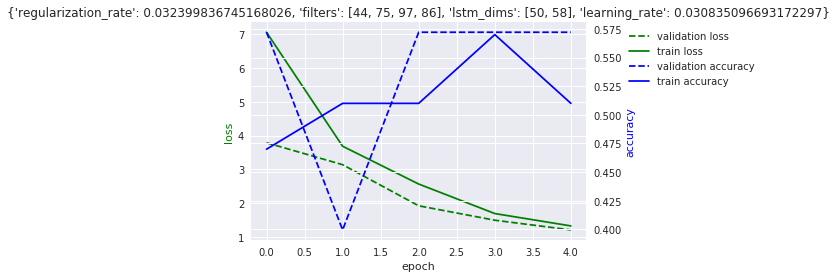

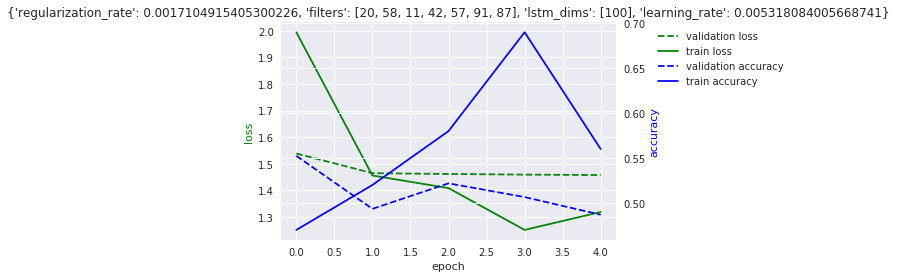

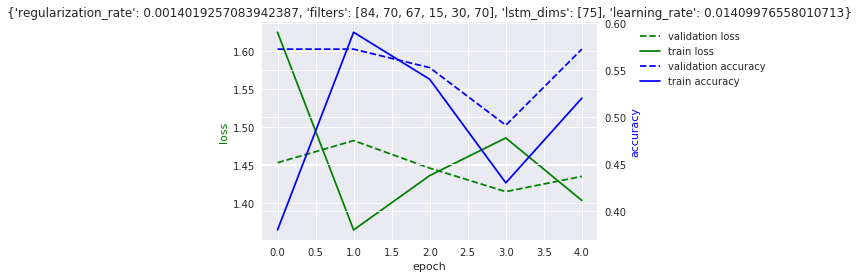

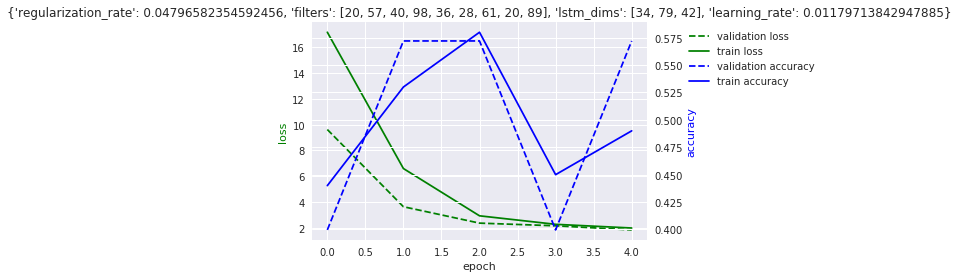

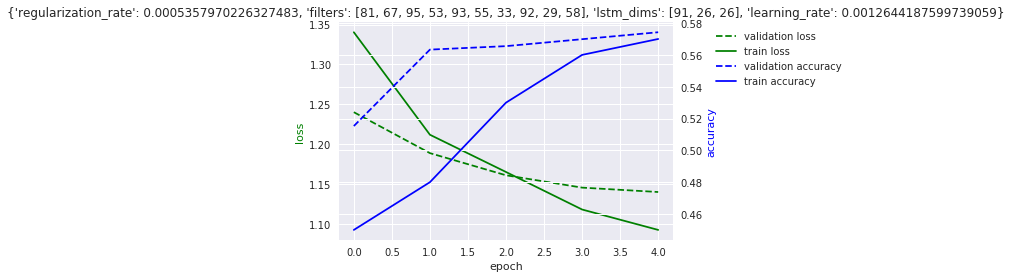

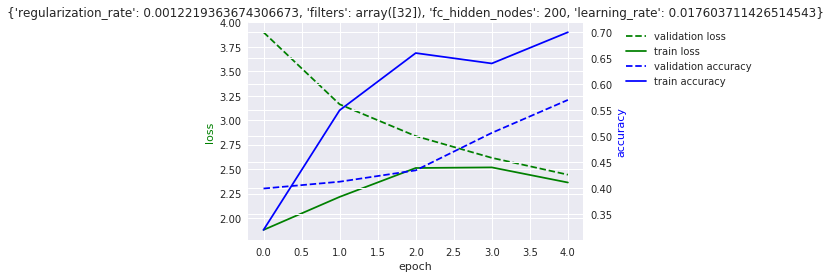

In [6]:
global_start_time = time.time()
epochs  = 5000
seq_len = 50

df = pd.read_csv('@NQ_Daily.txt', sep=',')
df = df.drop(["Date","Time"], axis=1)

X_train, y_train, X_test, y_test, original_data = load_data(df.values, seq_len, 1)

best_model, best_params, best_model_type, kNN = mcfly.find_best_architecture(X_train, y_train, X_test, y_test, number_of_models=10, outputpath="mcfly_results/results")

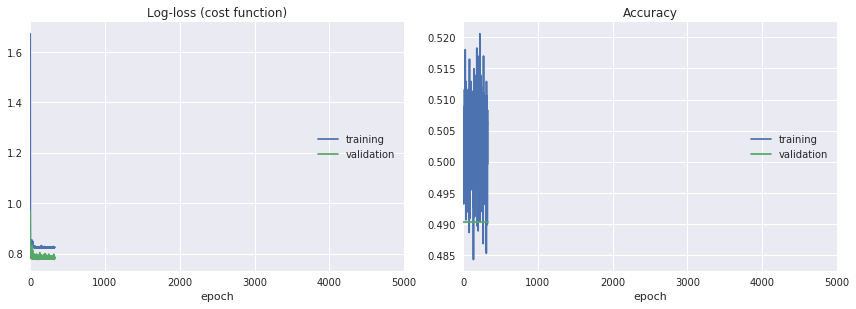

Epoch 329/5000
3104/3913 [======================>.......] - ETA: 3s - loss: 0.8360 - acc: 0.4968

In [ ]:
plot_losses = livelossplot.PlotLossesKeras()

hist = best_model.fit(X_train, y_train, epochs=epochs, validation_split=0.05, callbacks=[plot_losses])

log = pd.DataFrame(hist.history)
log.to_csv("classification_history.csv")

best_model.save('mcfly_model.h5')